Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0281 - val_loss: 0.0270
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0266 - val_loss: 0.0255
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0248 - val_loss: 0.0226
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0217 - val_loss: 0.0185
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0175 - val_loss: 0.0146
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0136 - val_loss: 0.0113
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0104 - val_loss: 0.0086
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0049 - val_loss: 0.0051
E

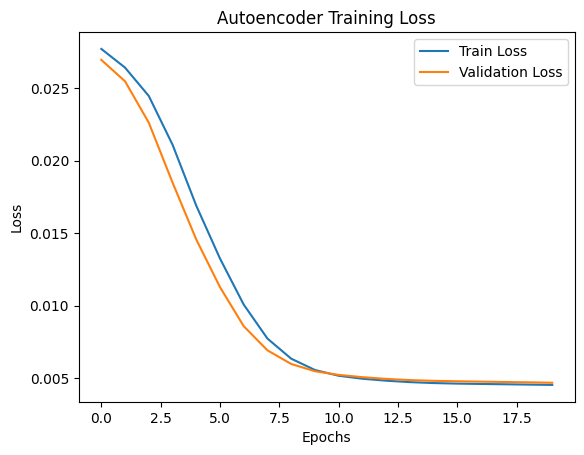

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Reconstruction error threshold: 0.02259892845003093

Confusion Matrix:
[[ 874 1205]
 [  92 2827]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.42      0.57      2079
         1.0       0.70      0.97      0.81      2919

    accuracy                           0.74      4998
   macro avg       0.80      0.69      0.69      4998
weighted avg       0.79      0.74      0.71      4998



In [1]:
# Assignment 4: ECG Anomaly Detection using Autoencoders

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# =====================
# 1. Load ECG Dataset
# =====================
url = "http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv"
data = pd.read_csv(url, header=None)

# Last column = labels (0 = anomaly, 1 = normal)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# =====================
# 2. Preprocessing
# =====================
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train only on "normal" samples (label = 1)
X_normal = X_scaled[y == 1]

# Split into train-test sets
x_train, x_test = train_test_split(X_normal, test_size=0.2, random_state=42)

# Also keep anomalies for evaluation
x_test_all = X_scaled
y_test_all = y

# =====================
# 3. Build Autoencoder
# =====================
input_dim = X.shape[1]  # number of features

input_layer = Input(shape=(input_dim,))
# Encoder
encoded = Dense(64, activation="relu")(input_layer)
encoded = Dense(32, activation="relu")(encoded)
encoded = Dense(16, activation="relu")(encoded)
# Decoder
decoded = Dense(32, activation="relu")(encoded)
decoded = Dense(64, activation="relu")(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# =====================
# 4. Train Autoencoder
# =====================
history = autoencoder.fit(x_train, x_train,
                          epochs=20,
                          batch_size=512,
                          validation_data=(x_test, x_test),
                          verbose=1)

# =====================
# 5. Plot Training Loss
# =====================
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Autoencoder Training Loss")
plt.show()

# =====================
# 6. Reconstruction Error
# =====================
reconstructions = autoencoder.predict(x_test_all)
mse = np.mean(np.power(x_test_all - reconstructions, 2), axis=1)

# Set threshold = mean + std of training reconstruction error
threshold = np.mean(mse) + np.std(mse)
print("Reconstruction error threshold:", threshold)

# =====================
# 7. Anomaly Detection
# =====================
y_pred = [0 if e > threshold else 1 for e in mse]

from sklearn.metrics import classification_report, confusion_matrix

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_all, y_pred))

print("\nClassification Report:")
print(classification_report(y_test_all, y_pred))
